In [1]:
import os
import gc
import cv2
import h5py
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from  matplotlib import pyplot as plt

In [2]:
mvsa_single_data_path = '../input/mvsasingle/MVSA_Single/data'
mvsa_single_label_path = '../input/mvsasingle/MVSA_Single/labelResultAll.txt'
mvsa_multiple_data_path = '../input/mvsamultiple/MVSA/data'
mvsa_multiple_label_path = '../input/mvsamultiple/MVSA/labelResultAll.txt'

IMAGE_SIZE = (224, 224)
NUM_CHANNELS = 3

In [3]:
def read_text_file(path, multi_line=False):
    if multi_line == True:
        lines = open(path, 'r', encoding='latin-1').readlines()
        lines = [line.rstrip('\n') for line in lines]
        return lines
    return open(path, 'r', encoding='latin-1').read()

def read_image_file(path):
    try:
        image = cv2.imread(path, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
#         image = tf.keras.utils.load_img(path, target_size=IMAGE_SIZE)
#         image = tf.keras.preprocessing.image.img_to_array(image)
        invalid_ID = -1
    except:
        image = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
        invalid_ID = int(os.path.split(path)[1].split('.')[0])
    return image, invalid_ID

def read_labels_file(path):
    dataframe = pd.read_csv(path, sep="\s+|,", engine="python")
    return dataframe

In [4]:
# since there are 3 annotators defining each data labels in the MVSA-Multiple dataset
# we take the labels pair that 2 out 3 annotators agree on as the valid labels pair, remove otherwise
def merge_multi_label(dataframe):
    anno_1 = list(dataframe.iloc[:, 1:3].itertuples(index=False, name=None))
    anno_2 = list(dataframe.iloc[:, 3:5].itertuples(index=False, name=None))
    anno_3 = list(dataframe.iloc[:, 5:7].itertuples(index=False, name=None))
    IDs = list(dataframe.iloc[:, 0])
    
    valid_pairs = []
    
    for i in range(len(anno_1)):
        pairs = [anno_1[i], anno_2[i], anno_3[i]]
        ID = IDs[i]
        
        text_labels = [pair[0] for pair in pairs]
        image_labels = [pair[1] for pair in pairs]
        
        max_occur_text_label = max(text_labels, key=text_labels.count)
        max_occur_image_label = max(image_labels, key=image_labels.count)

        if text_labels.count(max_occur_text_label) > 1 and image_labels.count(max_occur_image_label) > 1:
            valid_pair = (ID, max_occur_text_label, max_occur_image_label)
        else:
            valid_pair = (ID, 'invalid', 'invalid')
        valid_pairs.append(valid_pair)
    valid_dataframe = pd.DataFrame(valid_pairs, columns=['ID', 'text', 'image'])
    return valid_dataframe

# def old_merge_multi_label(dataframe):
#     anno_1 = list(dataframe.iloc[:, 1:3].itertuples(index=False, name=None))
#     anno_2 = list(dataframe.iloc[:, 3:5].itertuples(index=False, name=None))
#     anno_3 = list(dataframe.iloc[:, 5:7].itertuples(index=False, name=None))
#     IDs = list(dataframe.iloc[:, 0])
#     valid_pairs = []
#     for i in range(len(anno_1)):
#         pairs = [anno_1[i], anno_2[i], anno_3[i]]
#         ID = IDs[i]
#         valid_pair = tuple([pair for pair in pairs if pairs.count(pair) > 1])
#         if len(valid_pair) == 0:
#             valid_pair = (ID, 'invalid', 'invalid')
#         else:
#             valid_pair = (ID, valid_pair[0][0], valid_pair[0][1])
#         valid_pairs.append(valid_pair)
#     valid_dataframe = pd.DataFrame(valid_pairs, columns=['ID', 'text', 'image'])
#     return valid_dataframe

def multimodal_label(text_label, image_label):
    if text_label == image_label:
        label = text_label
    elif (text_label == 'positive' and image_label == 'negative') or (text_label == 'negative' and image_label == 'positive'):
        label = 'invalid'
    elif (text_label == 'neutral' and image_label != 'neutral') or (text_label != 'neutral' or image_label == 'neutral'):
        label = image_label if text_label == 'neutral' else text_label
    return label

In [5]:
def get_data_paths(path, extension):
    paths = os.listdir(path)
    paths.sort(key = lambda x : int(x.split('.')[0]))
    paths = list(filter(lambda x: x.endswith(extension), paths))
    paths = [os.path.join(path, x) for x in paths]
    return paths

def get_image_with_id(path):
    filename = os.path.split(path)[1]
    ID = int(filename.split('.')[0])
    image = read_image_file(path)
    return (ID, image)

In [6]:
def create_original_labels(path):
    dataframe = read_labels_file(path)
    text_labels = dataframe['text'].to_numpy()
    image_labels = dataframe['image'].to_numpy()
    return text_labels, image_labels

In [7]:
def create_multimodal_labels(path, multiple=False, mappings=False):
    dataframe = read_labels_file(path)
    
    if multiple == True:
        dataframe = merge_multi_label(dataframe)

    labels = []
    for label_pair in dataframe.iloc[:, 1:].values:
        label = multimodal_label(label_pair[0], label_pair[1])
        labels.append(label)
        
    if mappings == True:
        label_map = {}
        for i in range(len(labels)):
            ID = dataframe.iloc[i, 0]
            label_map[ID] = labels[i]            
        return label_map
    
    return np.array(labels, dtype='object')

def create_text_data(path):
    texts = []
    text_paths = get_data_paths(path, '.txt')
    
    print('Read text data')
    for text_path in tqdm(text_paths):
        text = read_text_file(text_path).rstrip('\n')
        texts.append(text)
        
    return texts

def create_image_data(path):
    images = []

    invalid_indices = []
    image_paths = get_data_paths(path, '.jpg')

    print('Read image data')
    for image_path in tqdm(image_paths):
        image, invalid_ID = read_image_file(image_path)
        images.append(image)

        if invalid_ID != -1:
            invalid_indices.append(invalid_ID)
            
    images = np.array(images, dtype='uint8')
    return images, invalid_indices

In [8]:
# def prenp_create_image_data(path):
#     invalid_indices = []
#     image_paths = get_data_paths(path, '.jpg')
#     images = np.zeros((len(image_paths), IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))

#     i = 0
#     print('Read image data')
#     for image_path in tqdm(image_paths):
#         image, invalid_ID = read_image_file(image_path)
        
#         images[i] = image
#         i+=1
#         if invalid_ID != -1:
#             invalid_indices.append(invalid_ID)
            
#     return images, invalid_indices

# def np_create_image_data(path):
#     images = np.array([])

#     invalid_indices = []
#     image_paths = get_data_paths(path, '.jpg')

#     print('Read image data')
#     for image_path in tqdm(image_paths):
#         image, invalid_ID = read_image_file(image_path)
#         if images.shape[0] == 0:
#             images = np.array([image])
#         else:
#             images = np.concatenate((images, [image]))

#         if invalid_ID != -1:
#             invalid_indices.append(invalid_ID)
            
#     return images, invalid_indices

In [9]:
def remove_invalid(data, indices):
    valid_data = []
    for i in range(len(data)):
        if i not in indices:
            valid_data.append(data[i])
    return valid_data

In [10]:
def save_text_file(filename, lines):
    with open(filename, 'w', encoding='latin1') as f:
        f.write('\n'.join(lines))

In [11]:
# for loading saved output data
def load_mvsa_data(path):
    read_file = h5py.File(path, 'r')
    
    texts = read_file['texts'][:]
    texts = np.array([x.decode('UTF-8') for x in texts]) # decode to utf-8 because hd5py save text object as binary string b'' thingy
    
    images = read_file['images'][:]
    
    multimodal_labels = read_file['multimodal-labels'][:]
    multimodal_labels = np.array([x.decode('UTF-8') for x in multimodal_labels])

    text_labels = read_file['text-labels'][:]
    text_labels = np.array([x.decode('UTF-8') for x in text_labels])

    image_labels = read_file['image-labels'][:]
    image_labels = np.array([x.decode('UTF-8') for x in image_labels])

    return texts, images, multimodal_labels, text_labels, image_labels

# Read and process raw data

## MVSA-Single

In [12]:
mvsa_single_texts = create_text_data(mvsa_single_data_path)
mvsa_single_images, mvsa_single_images_invalid_indices = create_image_data(mvsa_single_data_path)
mvsa_single_multimodal_labels = create_multimodal_labels(mvsa_single_label_path)
mvsa_single_text_labels, mvsa_single_image_labels = create_original_labels(mvsa_single_label_path)
num_mvsa_single = len(mvsa_single_texts)

Read text data


100%|██████████| 4869/4869 [00:15<00:00, 323.36it/s]


Read image data


100%|██████████| 4869/4869 [00:58<00:00, 83.40it/s]


In [13]:
# Get duplicated text indices
mvsa_single_texts_unique_indices = np.unique(mvsa_single_texts, return_index=True)[1]
mvsa_single_texts_duplicated_indices = [i for i in range(num_mvsa_single) if i not in mvsa_single_texts_unique_indices]

# Get invalid label indices
mvsa_single_multimodal_labels_invalid_indices = [i for i in range(num_mvsa_single) if mvsa_single_multimodal_labels[i] == 'invalid']

In [14]:
print('Number of text-image pair in MVSA-Single:', num_mvsa_single)

mvsa_single_invalid_indices = []
mvsa_single_invalid_indices.extend(mvsa_single_texts_duplicated_indices)
mvsa_single_invalid_indices.extend(mvsa_single_images_invalid_indices) # corrupted images
mvsa_single_invalid_indices.extend(mvsa_single_multimodal_labels_invalid_indices)
mvsa_single_invalid_indices = list(set(mvsa_single_invalid_indices))
print('Number of invalid data in MVSA-Single:', len(mvsa_single_invalid_indices))

mvsa_single_texts_valid = remove_invalid(mvsa_single_texts, mvsa_single_invalid_indices)
mvsa_single_images_valid = remove_invalid(mvsa_single_images, mvsa_single_invalid_indices)
mvsa_single_multimodal_labels_valid = remove_invalid(mvsa_single_multimodal_labels, mvsa_single_invalid_indices)
mvsa_single_text_labels_valid = remove_invalid(mvsa_single_text_labels, mvsa_single_invalid_indices)
mvsa_single_image_labels_valid = remove_invalid(mvsa_single_image_labels, mvsa_single_invalid_indices)

num_mvsa_single_valid = len(mvsa_single_texts_valid)
print('Number of text-image pair in MVSA-Single after removing invalid data:', num_mvsa_single_valid)

Number of text-image pair in MVSA-Single: 4869
Number of invalid data in MVSA-Single: 553
Number of text-image pair in MVSA-Single after removing invalid data: 4316


In [15]:
# save and load check data
with h5py.File('mvsa-single-{}.hdf5'.format(num_mvsa_single_valid), 'w') as f:
    f.create_dataset('texts', data = mvsa_single_texts_valid)
    f.create_dataset('images', data = mvsa_single_images_valid)
    f.create_dataset('multimodal-labels', data = mvsa_single_multimodal_labels_valid)
    f.create_dataset('text-labels', data = mvsa_single_text_labels_valid)
    f.create_dataset('image-labels', data = mvsa_single_image_labels_valid)
    
mvsa_single_texts_loaded, mvsa_single_images_loaded, \
mvsa_single_multimodal_labels_loaded, mvsa_single_text_labels_loaded, \
mvsa_single_image_labels_loaded = load_mvsa_data('./mvsa-single-4316.hdf5')

print((mvsa_single_texts_valid == mvsa_single_texts_loaded).all())
print((mvsa_single_images_valid == mvsa_single_images_loaded).all())
print((mvsa_single_multimodal_labels_valid == mvsa_single_multimodal_labels_loaded).all())
print((mvsa_single_text_labels_valid == mvsa_single_text_labels_loaded).all())
print((mvsa_single_image_labels_valid == mvsa_single_image_labels_loaded).all())

True
True
True
True
True


## MVSA-Multiple

In [16]:
mvsa_multiple_texts = create_text_data(mvsa_multiple_data_path)
mvsa_multiple_images, mvsa_multiple_images_invalid_indices = create_image_data(mvsa_multiple_data_path)
mvsa_multiple_multimodal_labels = create_multimodal_labels(mvsa_multiple_label_path, multiple=True)
mvsa_multiple_text_labels, mvsa_multiple_image_labels = create_original_labels(mvsa_multiple_label_path)
num_mvsa_multiple = len(mvsa_multiple_texts)

Read text data


100%|██████████| 19600/19600 [01:02<00:00, 314.87it/s]


Read image data


100%|██████████| 19600/19600 [04:12<00:00, 77.65it/s]


In [17]:
# Get duplicated text indices
mvsa_multiple_texts_unique_indices = np.unique(mvsa_multiple_texts, return_index=True)[1]
mvsa_multiple_texts_duplicated_indices = [i for i in range(num_mvsa_multiple) if i not in mvsa_multiple_texts_unique_indices]

# Get invalid label indices
mvsa_multiple_multimodal_labels_invalid_indices = [i for i in range(num_mvsa_multiple) if mvsa_multiple_multimodal_labels[i] == 'invalid']

In [18]:
print('Number of text-image pair in MVSA-Multiple:', num_mvsa_multiple)

mvsa_multiple_invalid_indices = []
mvsa_multiple_invalid_indices.extend(mvsa_multiple_texts_duplicated_indices)
mvsa_multiple_invalid_indices.extend(mvsa_multiple_images_invalid_indices)
mvsa_multiple_invalid_indices.extend(mvsa_multiple_multimodal_labels_invalid_indices)
mvsa_multiple_invalid_indices = list(set(mvsa_multiple_invalid_indices))
print('Number of invalid data in MVSA-Multiple:', len(mvsa_multiple_invalid_indices))

mvsa_multiple_texts_valid = remove_invalid(mvsa_multiple_texts, mvsa_multiple_invalid_indices)
mvsa_multiple_images_valid = remove_invalid(mvsa_multiple_images, mvsa_multiple_invalid_indices)
mvsa_multiple_multimodal_labels_valid = remove_invalid(mvsa_multiple_multimodal_labels, mvsa_multiple_invalid_indices)
mvsa_multiple_text_labels_valid = remove_invalid(mvsa_multiple_text_labels, mvsa_multiple_invalid_indices)
mvsa_multiple_image_labels_valid = remove_invalid(mvsa_multiple_image_labels, mvsa_multiple_invalid_indices)

num_mvsa_multiple_valid = len(mvsa_multiple_texts_valid)
print('Number of text-image pair in MVSA-Multiple after removing invalid data:', num_mvsa_multiple_valid)

Number of text-image pair in MVSA-Multiple: 19600
Number of invalid data in MVSA-Multiple: 3213
Number of text-image pair in MVSA-Multiple after removing invalid data: 16387


In [19]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

In [20]:
# save data to file
with h5py.File('mvsa-multiple-{}.hdf5'.format(num_mvsa_multiple_valid), 'w') as f:
    f.create_dataset('texts', data = mvsa_multiple_texts_valid)
#     f.create_dataset('images', data = a, compression="gzip")
    f.create_dataset('multimodal-labels', data = mvsa_multiple_multimodal_labels_valid)
    f.create_dataset('text-labels', data = mvsa_multiple_text_labels_valid)
    f.create_dataset('image-labels', data = mvsa_multiple_image_labels_valid)
    
# save as npz since h5py has a memory issues when saving upto 16k data somehow but 13k was fine :)
np.savez('./mvsa-multiple-{}-images'.format(num_mvsa_multiple_valid), mvsa_multiple_images_valid)

In [21]:
# for loading saved output data
def load_mvsa_multiple(path): # temporary fix
    read_file = h5py.File(path, 'r')
    
    texts = read_file['texts'][:]
    texts = np.array([x.decode('UTF-8') for x in texts]) # decode to utf-8 because hd5py save text object as binary string b'' thingy
    
#     images = read_file['images'][:]
    
    multimodal_labels = read_file['multimodal-labels'][:]
    multimodal_labels = np.array([x.decode('UTF-8') for x in multimodal_labels])

    text_labels = read_file['text-labels'][:]
    text_labels = np.array([x.decode('UTF-8') for x in text_labels])

    image_labels = read_file['image-labels'][:]
    image_labels = np.array([x.decode('UTF-8') for x in image_labels])

    return texts, multimodal_labels, text_labels, image_labels

In [22]:
mvsa_multiple_texts_loaded, mvsa_multiple_multimodal_labels_loaded, \
mvsa_multiple_text_labels_loaded, \
mvsa_multiple_image_labels_loaded = load_mvsa_multiple('./mvsa-multiple-{}.hdf5'.format(num_mvsa_multiple_valid))

npzfile = np.load('./mvsa-multiple-{}-images.npz'.format(num_mvsa_multiple_valid))
mvsa_multiple_images_loaded = npzfile['arr_0']

In [23]:
# np.savez('./mvsa-multiple-images', a)
# npzfile = np.load('./mvsa-multiple-{}-images.npz'.format(num_mvsa_multiple_valid))
# mvsa_multiple_images_loaded = npzfile['arr_0']

In [24]:
print((mvsa_multiple_texts_valid == mvsa_multiple_texts_loaded).all())
print((mvsa_multiple_images_valid == mvsa_multiple_images_loaded).all())
print((mvsa_multiple_multimodal_labels_valid == mvsa_multiple_multimodal_labels_loaded).all())
print((mvsa_multiple_text_labels_valid == mvsa_multiple_text_labels_loaded).all())
print((mvsa_multiple_image_labels_valid == mvsa_multiple_image_labels_loaded).all())

True
True
True
True
True


# Visualization

In [25]:
mvsa_single_multimodal_labels_valid = np.array(mvsa_single_multimodal_labels_valid)
mvsa_multiple_multimodal_labels_valid = np.array(mvsa_multiple_multimodal_labels_valid)

In [26]:
mvsa_single_num_pos = (mvsa_single_multimodal_labels_valid == 'positive').sum()
mvsa_single_num_neg = (mvsa_single_multimodal_labels_valid == 'negative').sum()
mvsa_single_num_neu = (mvsa_single_multimodal_labels_valid == 'neutral').sum()

mvsa_multiple_num_pos = (mvsa_multiple_multimodal_labels_valid == 'positive').sum()
mvsa_multiple_num_neg = (mvsa_multiple_multimodal_labels_valid == 'negative').sum()
mvsa_multiple_num_neu = (mvsa_multiple_multimodal_labels_valid == 'neutral').sum()

In [27]:
def get_label_num(data_labels, name=''):
    unique_labels = np.unique(data_labels)
    num_labels = [(data_labels == label).sum() for label in  unique_labels]
    dataframe = pd.DataFrame(np.reshape(num_labels, (1, -1)), columns=unique_labels, index=[name])
    return dataframe

In [28]:
print('MVSA dataset after removing invalid and duplicated data')
mvsa_single_valid_label = get_label_num(mvsa_single_multimodal_labels_valid, 'MVSA-Single')
mvsa_multiple_valid_label = get_label_num(mvsa_multiple_multimodal_labels_valid, 'MVSA-Multiple')
mvsa_valid_label = get_label_num(np.append(mvsa_single_multimodal_labels_valid, mvsa_multiple_multimodal_labels_valid, axis=0), 'Total MVSA')
mvsa_valid_label = pd.concat([mvsa_single_valid_label, mvsa_multiple_valid_label, mvsa_valid_label])
mvsa_valid_label['total'] = mvsa_valid_label.sum(axis = 1)
mvsa_valid_label

MVSA dataset after removing invalid and duplicated data


,negative,neutral,positive,total
MVSA-Single,1311,448,2557,4316
MVSA-Multiple,1257,4117,11013,16387
Total MVSA,2568,4565,13570,20703


In [29]:
positive_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_valid[i] == 'positive']
negative_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_valid[i] == 'negative']
neutral_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_valid[i] == 'neutral']

Positive images


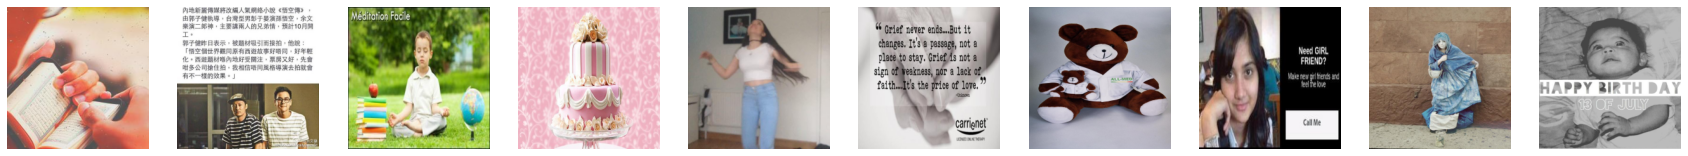

In [30]:
rows = 1
columns = 10

fig = plt.figure(figsize=(30, 5))
print('Positive images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    positive_image_indices
    random_index = random.choice(positive_image_indices)
    plt.imshow(mvsa_single_images_valid[random_index][:, :, ::-1])
    plt.axis('off')
plt.show()

Negative images


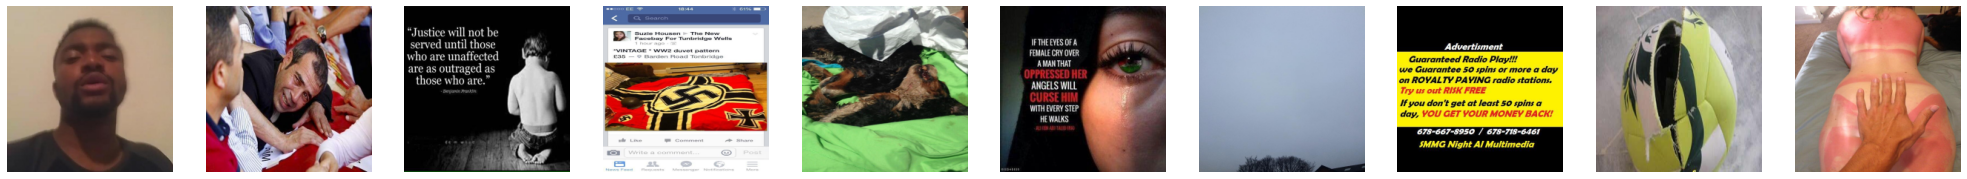

In [31]:
fig = plt.figure(figsize=(35, 10))
print('Negative images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(negative_image_indices)
    plt.imshow(mvsa_single_images_valid[random_index][:, :, ::-1])
    plt.axis('off')
plt.show()

Neutral images


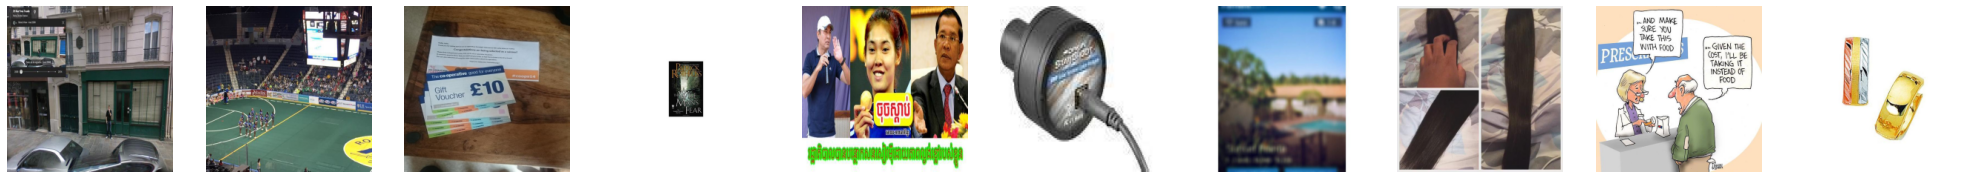

In [32]:
fig = plt.figure(figsize=(35, 10))
print('Neutral images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(neutral_image_indices)
    plt.imshow(mvsa_single_images_valid[random_index][:, :, ::-1])
    plt.axis('off')
plt.show()

# Feature Extraction

In [33]:
# import torch

# from transformers import BertTokenizer, BertForMaskedLM, BertModel
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg19 import VGG19
# from keras.models import Model

## BERT-base

In [34]:
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')# bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict = True)
# bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# # bert_model.eval() # (evaluation mode is default) put model in evaluation model, turn of regularization in training

In [35]:
# def bert_embed_sentence(text, tokenizer=bert_tokenizer, model=bert_model):
# #     inputs = tokenizer(text, return_tensors='pt', max_length=MAX_LENGTH, padding='max_length')
#     inputs = tokenizer(text, return_tensors='pt')
#     with torch.no_grad():
#         outputs = model(**inputs, )
#         last_hidden_states = outputs.hidden_states[-1][0]
#         cls_token = last_hidden_states[0]
#         bert_embeddings = torch.squeeze(cls_token, dim=0).numpy()
#     return bert_embeddings

In [36]:
# def bert_embed_data(data):
#     embedded_data = np.array([])
#     for line in tqdm(data):
#         bert_embeddings = bert_embed_sentence(line)
#         if embedded_data.shape[0] == 0:
#             embedded_data = np.array([bert_embeddings])#np.empty((0, embedded_line.shape[0]), 'float32')
#         else:
#             embedded_data = np.concatenate((embedded_data, [bert_embeddings]))
#     return embedded_data

In [37]:
# print('MVSA-Single: Extracting bert features of texts')
# mvsa_single_texts_bert = bert_embed_data(mvsa_single_texts_valid)
# print('BERT-base CLS token in last hidden layer dimension:', mvsa_single_texts_bert.shape[1])
# print('MVSA-Single with BERT-base CLS token in last hidden layer:', mvsa_single_texts_bert.shape)

In [38]:
# print('MVSA-Multiple: Extracting bert features of texts')
# mvsa_multiple_texts_bert = bert_embed_data(mvsa_multiple_texts_valid)
# print('BERT-base CLS token in last hidden layer dimenion:', mvsa_multiple_texts_bert.shape[1])
# print('MVSA-Multiple with BERT-base CLS token in last hidden layer:', mvsa_multiple_texts_bert.shape)

## VGG-16

In [39]:
# vgg16 = VGG16(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
# vgg16.trainable = False # Freeze pre-trained layers
# model_vgg16 = Model(inputs=vgg16.input, outputs=vgg16.layers[-2].output) # output of last hidden layer (before classification layer)

In [40]:
# print('MVSA-Single: Extracting VGG-16 features of images')
# mvsa_single_images_vgg16 = model_vgg16.predict(mvsa_single_images_valid[:5], verbose=1)

## VGG-19

In [41]:
# vgg19 = VGG19(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
# vgg19.trainable = False # Freeze pre-trained layers
# model_vgg19 = Model(inputs=vgg19.input, outputs=vgg19.layers[-2].output) # output of last hidden layer (before classification layer)

# Drafts

In [42]:
# def old_remove_invalid(data, indices):
#     new_data =  np.delete(data, indices, axis=0)
#     return new_data

In [43]:
# def old_create_image_data(path):
#     images = np.array([])

#     invalid_indices = []
#     image_paths = get_data_paths(path, '.jpg')

#     print('Read image data')
#     for image_path in tqdm(image_paths):
#         image, invalid_ID = read_image_file(image_path)
#         if images.shape[0] == 0:
#             images = np.array([image])
#         else:
#             images = np.concatenate((images, [image]))

#         if invalid_ID != -1:
#             invalid_indices.append(invalid_ID)
            
#     return images, invalid_indices

In [44]:
# # save_text_file('./mvsa-multiple-texts.txt', mvsa_multiple_texts_valid)
# np.save('./mvsa-multiple-images.npy', mvsa_multiple_images_valid)
# # save_text_file('./mvsa-multiple-labels.txt', mvsa_multiple_multimodal_labels_valid)

# # mvsa_multiple_texts_loaded = read_text_file('./mvsa-multiple-texts.txt', multi_line=True)
# mvsa_multiple_images_loaded = np.load('./mvsa-multiple-images.npy')
# # mvsa_multiple_multimodal_labels_loaded = read_text_file('./mvsa-multiple-labels.txt', multi_line=True)

# # print((mvsa_multiple_texts_valid == mvsa_multiple_texts_loaded).all())
# print((mvsa_multiple_images_loaded == mvsa_multiple_images_valid).all())
# # print((mvsa_multiple_multimodal_labels_valid == mvsa_multiple_multimodal_labels_loaded).all())

In [45]:
# # Open HDF5 and create datasets in advance
# save_file = h5py.File('mvsa-multiple-{}.hdf5'.format(mvsa_multiple_texts_valid.shape[0]), 'w')
# save_file.create_dataset("data_image", (200000,224,224), dtype='uint8')
# save_file.create_dataset("data_label", (200000,), dtype='int64')
# f.create_dataset('texts', len(mvsa_multiple_texts_valid), dtype='object')
# f.create_dataset('images', data = mvsa_multiple_images_valid)
# f.create_dataset('multimodal-labels', data = mvsa_multiple_multimodal_labels_valid)
# f.create_dataset('text-labels', data = mvsa_multiple_text_labels_valid)
# f.create_dataset('image-labels', data = mvsa_multiple_image_labels_valid)

# label_list = os.listdir('root')
# img_cnt = 0
# for i, label in enumerate(label_list):
#     files = os.listdir(os.path.join('root', label_list))
#     for filename in files:
#         img = Image.open(os.path.join('root', label, filename))
#         ow, oh = 128, 128
#         img = img.resize((ow, oh), Image.BILINEAR)
#         save_file["data_image"][img_cnt,:,:] = np.array(img).tolist())
#         save_file["data_label"][img_cnt] = i
#         img_cnt += 1

# datafile.close()

In [46]:
# save_text_file('./mvsa-multiple-texts.txt', mvsa_multiple_texts_valid)
# np.save('./mvsa-multiple-images.npy', mvsa_multiple_images_valid)
# save_text_file('./mvsa-multiple-labels.txt', mvsa_multiple_multimodal_labels_valid)

# mvsa_multiple_texts_loaded = read_text_file('./mvsa-multiple-texts.txt', multi_line=True)
# mvsa_multiple_images_loaded = np.load('./mvsa-multiple-images.npy')
# mvsa_multiple_multimodal_labels_loaded = read_text_file('./mvsa-multiple-labels.txt', multi_line=True)

# print((mvsa_multiple_texts_valid == mvsa_multiple_texts_loaded).all())
# print((mvsa_multiple_images_loaded == mvsa_multiple_images_valid).all())
# print((mvsa_multiple_multimodal_labels_valid == mvsa_multiple_multimodal_labels_loaded).all())

In [47]:
## OLD SAVE AND LOAD DATA WITH NPY FILE

# save_text_file('./mvsa-single-texts.txt', mvsa_single_texts_valid)
# np.save('./mvsa-single-images.npy', mvsa_single_images_valid)
# save_text_file('./mvsa-single-labels.txt', mvsa_single_multimodal_labels_valid)

# mvsa_single_texts_loaded = read_text_file('./mvsa-single-texts.txt', multi_line=True)
# mvsa_single_images_loaded = np.load('./mvsa-single-images.npy')
# mvsa_single_multimodal_labels_loaded = read_text_file('./mvsa-single-labels.txt', multi_line=True)

In [48]:
# mvsa_single_images_unique_indices = np.unique([image.flatten() for image in mvsa_single_images], return_index=True, return_counts=True)
# mvsa_single_images_duplicated_indices = [i for i in range(mvsa_single_images.shape[0]) if i not in mvsa_single_images_unique_indices]

## ---> doesn't work, only compare unique numbers not unique list

In [49]:
# if extracted_data.shape[0] == 0:
#     extracted_data = np.concatenate(([extracted_data], [features]), 1)
# else:
#     extracted_data = np.concatenate((extracted_data, [features]), 0)

In [50]:
# # mvsa_single_images.tofile('./mvsa-single-images.npy')
# np.save('./mvsa-single-images.npy', mvsa_single_images)
# mvsa_single_images_loaded = np.load('./mvsa-single-images.npy')
# (mvsa_single_images_loaded == mvsa_single_images).all()

In [51]:
# a = read_labels_file(mvsa_single_label_path).iloc[:, 1:].values
# for i in a:
#     if i[0] == 'negative' and i[1] == 'positive':
#         print('here')
#     elif i[0] == 'positive' and i[1] == 'negative':
#         print('hereee')

In [52]:
# label_mappings = create_labels(mvsa_single_label_path, mappings=True)

# image_dataset = make_dataset([os.path.join(mvsa_single_label_path, str(ID) + '.jpg') for ID in label_mappings.keys()],
#                              list(label_mappings.values()))

In [53]:
# a = get_image_with_id(os.path.join(mvsa_single_data_path, '1.jpg'))
# tf.keras.utils.array_to_img(a[1])

In [54]:
# label_mappings = create_labels(mvsa_single_label_path, mappings=True)

# image_dataset = make_dataset([os.path.join(mvsa_single_label_path, str(ID) + '.jpg') for ID in label_mappings.keys()],
#                              list(label_mappings.values()))

In [55]:
# a = os.listdir(mvsa_single_data_path)
# a.sort(key = lambda x: int(x.split('.')[0]))
# list(filter(lambda x: x.endswith('.jpg'), a))
# a = [os.path.join(mvsa_single_data_path, i) for i in a]
# a

In [56]:
# # a = create_labels(mvsa_multiple_label_path, multiple=True, mappings=True)
# def process_image(path, label):
# #     filename = os.path.split(path)[1]
# #     ID = int(filename.split('.')[0])
# #     return read_image_file(path), label_map[ID]
#     return read_image_file(path), label

# def make_dataset(images, labels):
#     dataset = tf.data.Dataset.from_tensor_slices((images, labels))
# #     dataset = dataset.shuffle(len(images))
#     dataset = dataset.map(process_image)#, num_parallel_calls=AUTOTUNE)
# #     dataset = dataset.batch(100).prefetch(tf.data.AUTOTUNE)
#     return dataset

In [57]:
# IMAGE_SIZE = (224, 224)
# def read_image_file(path):
#     image = cv2.imread(path, cv2.COLOR_BGR2RGB)
# #     image = np.array(image)#.astype('float32')
# #     image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
# #     image /= 255
# #     print(image.shape)
# #     ax = plt.subplot(1,2,1)
# #     plt.imshow(image)
# #     image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
# #     ax = plt.subplot(1,2,2)
# #     plt.imshow(image)
# #     print(image.shape)
#     return image
# read_image_file('../input/mvsasingle/MVSA_Single/data/10.jpg')      

In [58]:
# def read_text_file(path, multi_line=False):
# #     with open(path, 'r', encoding='latin-1') as f:
# #         if multi_line == True:
# #             lines = f.readlines()
# #             lines = [line.rstrip('\n') for line in lines]
# #             return lines
# #         return f.read()
    
#     if multi_line == True:
#         lines = open(path, 'r', encoding='latin-1').readlines()
#         lines = [line.rstrip('\n') for line in lines]
#         return lines
#     return open(path, 'r', encoding='latin-1').read()

# def read_image_file(path):
#     try:
#         image = cv2.imread(path, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
#     except:
#         image = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
#         ID = os.path.split(path)[1].split('.')[0]
#         invalid_indices.append(ID)
# #     image = tf.io.read_file(path)
# #     image = tf.image.decode_jpeg(image, channels=NUM_CHANNELS)
# #     image = tf.image.resize(image, IMAGE_SIZE)
#     return image

# def read_labels_file(path):
#     dataframe = pd.read_csv(path, sep="\s+|,", engine="python")
#     return dataframe

In [59]:
# def create_labels(path, multiple=False, mappings=False):
#     dataframe = read_labels_file(path)
    
#     if multiple == True:
#         dataframe = merge_multi_label(dataframe)
        
#     labels = []
#     for _, row in dataframe.iterrows():
#         label = multimodal_label(row['text'], row['image'])
#         labels.append(label)
        
#     if mappings == True:
#         label_map = {}
#         for i in range(len(labels)):
#             ID = dataframe.iloc[i, 0]
#             label_map[ID] = labels[i]            
#         return label_map
#     return np.array(labels, dtype='object')

# def create_text_data(path):
#     texts = []
    
#     print('Read text data')
#     # read data along with its filename as ID
#     for filename in tqdm(os.listdir(path)):
#         ID = int(filename.split('.')[0])
#         file_path = os.path.join(path, filename)
#         if filename.endswith('txt'):
#             text = read_text_file(file_path)
#             texts.append((ID, text))

#     # Sort data by its ID
#     get_ID = lambda x : x[0]
#     texts.sort(key=get_ID)
    
#     # return data without ID
#     texts = np.array([text[1].rstrip('\n') for text in texts])

#     return texts

# def create_image_data(path):
#     images = []
     
#     image_paths = os.listdir(path)
#     image_paths.sort(key = lambda x : int(x.split('.')[0]))
#     image_paths = list(filter(lambda x: x.endswith('.jpg'), image_paths))
#     image_paths = [os.path.join(path, x) for x in image_paths]
# #     print(image_path)
    
#     print('Read image data')
#     # read data along with its filename as ID
#     for image_path in tqdm(image_paths):
# #         ID = int(filename.split('.')[0])
# #         file_path = os.path.join(path, filename)
# #         gc.collect()
# #         if filename.endswith('jpg'):
# #         image_with_id = get_image_with_id(image_path)
# #         images.append(image_with_id)
#         image = read_image_file(image_path)
#         images.append(image)
# #         del image
# #         gc.collect()
        
    
# #     # Sort data by its ID
# #     get_ID = lambda x : x[0]
# #     images.sort(key=get_ID)
    
#     # return data without ID
# #     images = np.array([image[1] for image in images], dtype='object')

#     return images

# def get_image_with_id(path):
#     filename = os.path.split(path)[1]
#     ID = int(filename.split('.')[0])
#     image = read_image_file(path)
#     return (ID, image)